In [1]:
# imports cell
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import warnings

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

In [2]:
filename = "./dataset/icml_face_data.csv"

#emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [3]:
dataset_df = pd.read_csv(filename)
dataset_df

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


array([[<AxesSubplot:title={'center':'emotion'}>]], dtype=object)

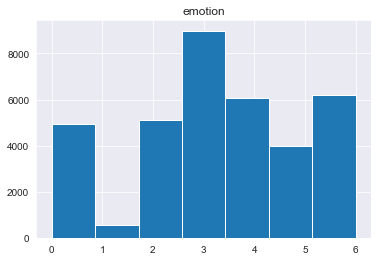

In [4]:
dataset_df.hist(column='emotion', bins=7)

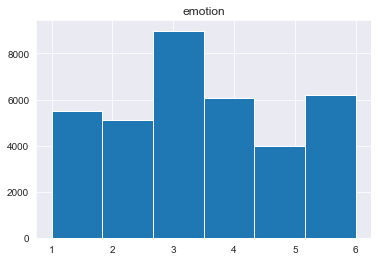

In [5]:
dataset_df['emotion'] = dataset_df['emotion'].replace(to_replace=0, value=1)
dataset_df.hist(column='emotion', bins=6)

emotions = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [6]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48), dtype=np.dtype('u1'))
    image_label = np.array(list(map(int, data['emotion'])), dtype=np.dtype('u1')).reshape(len(data), 1)

    for i, row in enumerate(data.index):
        image_array[i] = np.fromstring(data.loc[row, ' pixels'], dtype=np.dtype('u1'), sep=' ').reshape(48, 48)

    return image_array, image_label

In [7]:
x_train, y_train = prepare_data(dataset_df[dataset_df[' Usage'] == 'Training'])
x_val, y_val = prepare_data(dataset_df[dataset_df[' Usage'] == 'PrivateTest'])
x_test, y_test = prepare_data(dataset_df[dataset_df[' Usage'] == 'PublicTest'])

In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((28709, 48, 48),
 (28709, 1),
 (3589, 48, 48),
 (3589, 1),
 (3589, 48, 48),
 (3589, 1))

In [9]:
le = OneHotEncoder()
y_train = le.fit_transform(y_train).toarray()
y_val = le.fit_transform(y_val).toarray()
y_test = le.fit_transform(y_test).toarray()
y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [10]:
mu, st = 0, 255

test_transform = transforms.Compose([
    # transforms.Scale(52),
    transforms.ToPILImage(),
    transforms.TenCrop(40),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
])

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

    transforms.TenCrop(40),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
])


In [11]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.transform(self.images[index]).to(device)
        label = torch.tensor(self.labels[index], dtype=torch.float32, device=device)

        return image, label

In [12]:
trainDataset = CustomDataset(x_train, y_train, train_transform)

train_dataloader = DataLoader(trainDataset, batch_size=64, shuffle=True)

In [13]:
valDataset = CustomDataset(x_val, y_val, test_transform)

val_dataloader = DataLoader(valDataset, batch_size=64, shuffle=True)

In [14]:
testDataset = CustomDataset(x_test, y_test, test_transform)

test_dataloader = DataLoader(testDataset, batch_size=64, shuffle=True)

In [15]:
# Reference
# [1] Khaireddin, Yousif, and Zhuofa Chen.
# "Facial Emotion Recognition: State of the Art Performance on FER2013."
# arXiv preprint arXiv:2105.03588 (2021).

class VGG_Model(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(64)

        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(64)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2a = nn.BatchNorm2d(128)

        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2b = nn.BatchNorm2d(128)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3a = nn.BatchNorm2d(256)

        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.bn3b = nn.BatchNorm2d(256)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4a = nn.BatchNorm2d(512)

        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.bn4b = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512 * 2 * 2, 4096)

        self.fc2 = nn.Linear(4096, 4096)

        self.fc3 = nn.Linear(4096, 6)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.leaky_relu_(self.bn1a(self.conv1a(x)))
        x = F.leaky_relu_(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.leaky_relu_(self.bn2a(self.conv2a(x)))
        x = F.leaky_relu_(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.leaky_relu_(self.bn3a(self.conv3a(x)))
        x = F.leaky_relu_(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.leaky_relu_(self.bn4a(self.conv4a(x)))
        x = F.leaky_relu_(self.bn4b(self.conv4b(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.leaky_relu_(self.drop(self.fc1(x)))
        x = F.leaky_relu_(self.drop(self.fc2(x)))
        x = self.fc3(x)

        return x

In [16]:
def train_model(model, dataloader, optimizer, scaler, Ncrop=True):
    model.train()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()

    total_loss, total_acc = 0.0, 0.0

    for (data, label) in dataloader:

        with autocast():

            if Ncrop:
                # fuse crops and batchsize
                bs, ncrops, c, h, w = data.shape
                data = data.view(-1, c, h, w)

                # repeat labels ncrops times
                label = torch.repeat_interleave(label, repeats=ncrops, dim=0)

            # reset gradients (it will accumulate gradients otherwise)
            optimizer.zero_grad()

            # forward pass
            output = model(data)

            # compute loss
            loss_ = loss(output, label)

            # scale the loss then backward propagation dl/dw -> gradients
            scaler.scale(loss_).backward()

            # update weights
            scaler.step(optimizer)
            scaler.update()

            ######################################

            total_loss += loss_.item()

            _, predicted = torch.max(output.data, dim=1)
            _, true_label = torch.max(label, dim=1)

            pred += predicted.tolist()
            labels += true_label.tolist()


    total_loss /= len(dataloader)
    total_acc = accuracy_score(labels, pred) * 100.

    return total_acc, total_loss

In [17]:
def test_model(model, dataloader, Ncrop=True):
    model.eval()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss, total_acc, n_samples = 0.0, 0.0, 0.0

    with torch.no_grad():
        for (data, label) in dataloader:
            if Ncrop:
                # fuse crops and batchsize
                bs, ncrops, c, h, w = data.shape
                data = data.view(-1, c, h, w)

                # forward
                output = model(data)

                # combine results across the crops
                output = output.view(bs, ncrops, -1)
                output = torch.sum(output, dim=1) / ncrops
            else:
                output = model(data)

            # compute loss
            loss_ = loss(output, label)

            total_loss += loss_.item()

            _, predicted = torch.max(output.data, dim=1)
            _, true_label = torch.max(label, dim=1)

            pred += predicted.tolist()
            labels += true_label.tolist()

    total_loss /= len(dataloader)
    total_acc = accuracy_score(labels, pred) * 100.

    return labels, pred, total_acc, total_loss

In [18]:
def save_model(model, optimizer, epoch, path):
    info_dict = {
        'epoch': epoch,
        'net_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    torch.save(info_dict, path + ".pth")

In [19]:
model_path = "./VGG2_best_model"

model = VGG_Model().to(device)

print('Number of Parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of Parameters :  29886662


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001, amsgrad=True)

In [21]:
scaler = GradScaler()

In [22]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

In [23]:
chkpt = torch.load("./VGG2_best_model73_47.pth")
model.load_state_dict(chkpt['net_state'])
optimizer.load_state_dict(chkpt['optimizer_state'])
epoch_saved = chkpt['epoch'] + 1

optimizer.param_groups[0]['lr'] = 0.0001

#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1)

In [24]:
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

In [25]:
best_acc = 73.47

epoch = 50
# Train and validate model

for e in range(epoch):

    train_accuracy, train_loss = train_model(model, train_dataloader, optimizer, scaler)

    val_labels, val_pred, val_accuracy, val_loss = test_model(model, val_dataloader)

    # Decay Learning Rate
    scheduler.step(val_accuracy)

    if val_accuracy > best_acc:
        best_acc = val_accuracy
        save_model(model, optimizer, e, model_path+str(val_accuracy))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

        # print('Epoch ', e + 1,
        #       ": ->Training loss : {:.6f} - Training Accuracy : {:.6f} % \n        "
        #       "  -->Validate loss : {:.6f} - Validate Accuracy : {:.6f} %".format(train_loss,
        #                                                                          train_accuracy,
        #                                                                          val_loss,
        #                                                                          val_accuracy))
        #
    print('epoch: ', e + 100, 'Training loss: ', train_loss, 'Training Accuracy: ', train_accuracy, '%', '  Val loss: ',
          val_loss, 'Val Accuracy: ', val_accuracy, '%')
    print('learning rate :', optimizer.state_dict()['param_groups'][0]['lr'])

    # checkpoint
    if (e + 1) % 5 == 0 and e > 0:
        path = "./vgg2_epoch" + str(e + 1) + "_checkpoint"
        save_model(model, optimizer, e, path)



epoch:  100 Training loss:  0.5200367844051667 Training Accuracy:  80.57612595353373 %   Val loss:  1.0072842533128303 Val Accuracy:  69.60156032320981 %
learning rate : 1.3872870489469802e-06
epoch:  101 Training loss:  0.44326893032791886 Training Accuracy:  83.66679438503604 %   Val loss:  0.9614053661363167 Val Accuracy:  73.05656171635553 %
learning rate : 2.2120784836522925e-05
epoch:  102 Training loss:  0.4047908196868769 Training Accuracy:  85.00888223205266 %   Val loss:  1.0681077241897583 Val Accuracy:  73.11228754527723 %
learning rate : 2.2835120071497498e-05
epoch:  103 Training loss:  0.3878142298396287 Training Accuracy:  85.59476122470305 %   Val loss:  1.0249107783300835 Val Accuracy:  73.16801337419894 %
learning rate : 2.355793403084666e-05
epoch:  104 Training loss:  0.3782315225338352 Training Accuracy:  86.04688425232506 %   Val loss:  1.060223378633198 Val Accuracy:  73.19587628865979 %
learning rate : 2.3922451404375314e-05
epoch:  105 Training loss:  0.367387

Best Val Model -> Val loss:  0.9431576749734711 Val Accuracy:  73.47450543326832 % 
Test loss:  1.060687566012667 Test Accuracy:  72.16494845360825 %


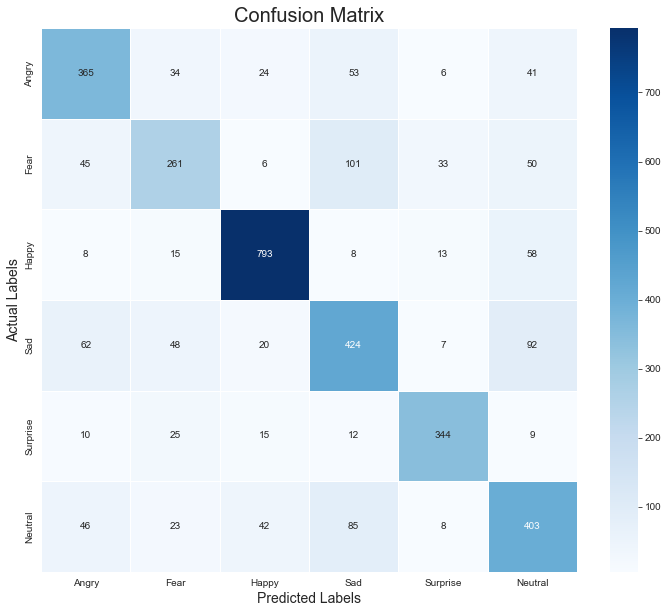

In [24]:
 # test model

model.load_state_dict(torch.load("VGG2_best_model73_47.pth")['net_state'])

val_labels, val_pred, val_accuracy, val_loss = test_model(model, val_dataloader)
print('Best Val Model -> Val loss: ', val_loss, 'Val Accuracy: ', val_accuracy, '% ')

test_labels, test_pred, test_accuracy, test_loss = test_model(model, test_dataloader)
print('Test loss: ', test_loss, 'Test Accuracy: ', test_accuracy, '%')

cm = confusion_matrix(test_labels, test_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=emotions, columns=emotions)

sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

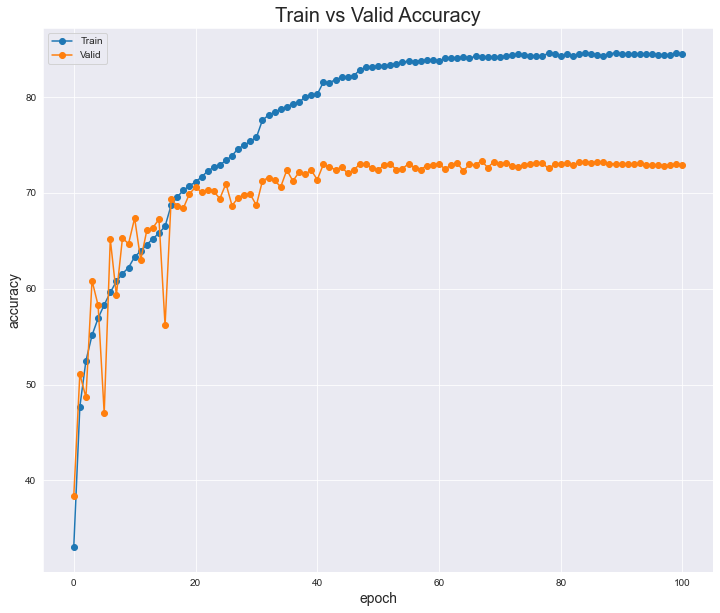

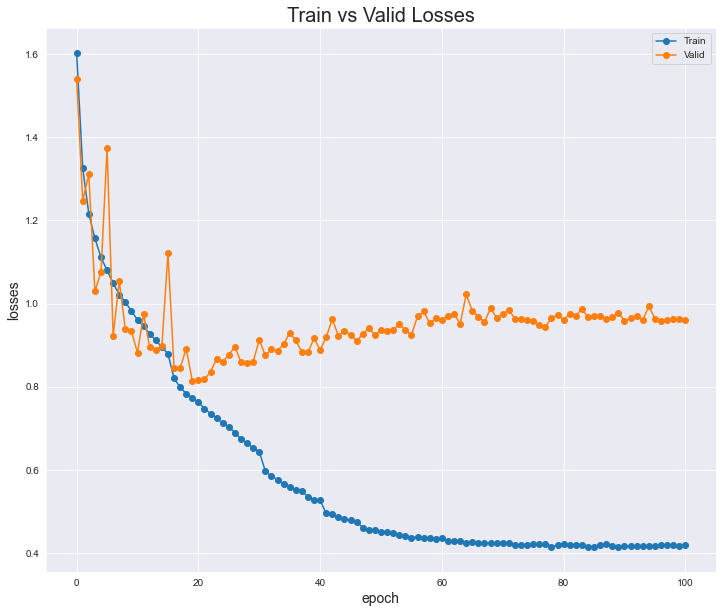

In [43]:
plt.figure(figsize=(12, 10))
plt.plot(train_acc_list, '-o')
plt.plot(val_acc_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('accuracy', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy', size=20)

plt.show()

plt.figure(figsize=(12, 10))
plt.plot(train_loss_list, '-o')
plt.plot(val_loss_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('losses', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses', size=20)

plt.show()